In [ ]:
!pip install geopandas

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import geopandas as gpd

In [ ]:
brasil = gpd.read_file('./drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/arquivos/brasil.shp')
eleitos = pd.read_csv('./drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/arquivos/eleitos.csv', sep=';', encoding='latin-1')

In [ ]:
eleitos.head()

,SQ_CANDIDATO,CD_MUNICIPIO,SG_UF,QT_VOTOS_NOMINAIS_VALIDOS,QT_VOTOS_NOMINAIS_VALIDOS_CAND,QT_VOTOS_NOMINAIS_VALIDOS_MUN,QT_VOTOS_NOMINAIS_VALIDOS_UF,g,QL,codigo_ibge,CD_SIT_TOT_TURNO
0,10001612484,1007,AC,270,16786,6904,418749,"1,6190238376726974e-07","0,9755949544943029",1200138,3
1,10001612484,1015,AC,197,16786,5782,418749,"4,292453511422678e-06","0,849952592636309",1200179,3
2,10001612484,1023,AC,428,16786,9551,418749,"7,230859025246662e-06","1,1178962211343662",1200807,3
3,10001612484,1031,AC,131,16786,2443,418749,"3,881210085101669e-06","1,337686649874252",1200435,3
4,10001612484,1040,AC,69,16786,7834,418749,"0,0002130880586379429","0,21972126345851323",1200351,3


In [ ]:
votacao_eleitos = eleitos[['SQ_CANDIDATO', 'QT_VOTOS_NOMINAIS_VALIDOS_CAND']].drop_duplicates().QT_VOTOS_NOMINAIS_VALIDOS_CAND.sum()
votacao_por_cidade = eleitos[['codigo_ibge', 'QT_VOTOS_NOMINAIS_VALIDOS']].groupby(by='codigo_ibge', as_index=False).sum()
votacao_por_cidade['%_do_mun_na_Votacao_dos_Eleitos'] = votacao_por_cidade.QT_VOTOS_NOMINAIS_VALIDOS / votacao_eleitos
votacao_total = eleitos[['SG_UF', 'QT_VOTOS_NOMINAIS_VALIDOS_UF']].drop_duplicates().QT_VOTOS_NOMINAIS_VALIDOS_UF.sum()
votacao_municipio = eleitos[['codigo_ibge', 'QT_VOTOS_NOMINAIS_VALIDOS_MUN']].drop_duplicates()
votacao_municipio['%_do_mun_na_Votacao_total'] = votacao_municipio.QT_VOTOS_NOMINAIS_VALIDOS_MUN / votacao_total

In [ ]:
votacao_por_cidade = pd.merge(votacao_por_cidade, votacao_municipio, on='codigo_ibge', how='left')
votacao_por_cidade.drop(columns=['QT_VOTOS_NOMINAIS_VALIDOS', 'QT_VOTOS_NOMINAIS_VALIDOS_MUN'], inplace=True)
votacao_por_cidade['R'] = votacao_por_cidade['%_do_mun_na_Votacao_dos_Eleitos'] / votacao_por_cidade['%_do_mun_na_Votacao_total']

In [ ]:
# DataFrame com os Votos de cada municipio apenas entre os eleitos:
votacao_dos_eleitos_por_cidade = eleitos[['codigo_ibge', 'QT_VOTOS_NOMINAIS_VALIDOS']].groupby(by='codigo_ibge', as_index=False).sum()
estados = eleitos[['codigo_ibge', 'SG_UF']].drop_duplicates()
votacao_dos_eleitos_por_cidade = pd.merge(votacao_dos_eleitos_por_cidade, estados, how='left', on='codigo_ibge')

# DataFrame com a Votação total de cada UF entre os candidatos eleitos
votacao_cada_estado = votacao_dos_eleitos_por_cidade[['SG_UF', 'QT_VOTOS_NOMINAIS_VALIDOS']].groupby(by='SG_UF', as_index=False).sum()
votacao_cada_estado.rename(columns={'QT_VOTOS_NOMINAIS_VALIDOS': 'Votos_totais_na_UF'}, inplace=True)

# DataFrame com a porcentagem da votação de cada municipio em relação à votação total de sua UF
votacao_dos_eleitos_por_cidade = pd.merge(votacao_dos_eleitos_por_cidade, votacao_cada_estado, how='left', on='SG_UF')
votacao_dos_eleitos_por_cidade['Porcentagem_dos_eleitos_na_Camara'] = votacao_dos_eleitos_por_cidade.QT_VOTOS_NOMINAIS_VALIDOS / votacao_dos_eleitos_por_cidade.Votos_totais_na_UF
votacao_dos_eleitos_por_cidade.drop(columns=['QT_VOTOS_NOMINAIS_VALIDOS', 'Votos_totais_na_UF'], inplace=True)

# DataFrame com a porcentagem de votos totais de cada municipio dentro dos votos totais de cada UF
votacao_municipio = eleitos[['codigo_ibge', 'QT_VOTOS_NOMINAIS_VALIDOS_MUN']].drop_duplicates()
votacao_estado = eleitos[['SG_UF', 'QT_VOTOS_NOMINAIS_VALIDOS_UF']].drop_duplicates()
votacao_municipio = pd.merge(votacao_municipio, estados, how='left', on='codigo_ibge')
votacao_municipio = pd.merge(votacao_municipio, votacao_estado, how='left', on='SG_UF')
votacao_municipio['Porcentagem_ideal_na_Camara'] = votacao_municipio.QT_VOTOS_NOMINAIS_VALIDOS_MUN / votacao_municipio.QT_VOTOS_NOMINAIS_VALIDOS_UF
votacao_municipio.drop(columns=['QT_VOTOS_NOMINAIS_VALIDOS_MUN', 'QT_VOTOS_NOMINAIS_VALIDOS_UF'], inplace=True)

# Join dos dois DataFrames finais
representatividade_cada_municipio = pd.merge(votacao_dos_eleitos_por_cidade, votacao_municipio, how='left', on=['codigo_ibge', 'SG_UF'])
representatividade_cada_municipio['R'] = representatividade_cada_municipio.Porcentagem_dos_eleitos_na_Camara / representatividade_cada_municipio.Porcentagem_ideal_na_Camara
representatividade_cada_municipio.sort_values(by='R', ascending=False)

,codigo_ibge,SG_UF,Porcentagem_dos_eleitos_na_Camara,Porcentagem_ideal_na_Camara,R
299,1600212,AP,0.022591,0.009745,2.318103
70,1200500,AC,0.112937,0.050689,2.228032
5286,5107198,MT,0.002064,0.000930,2.218596
3170,3205101,ES,0.042146,0.019030,2.214767
65,1200393,AC,0.027107,0.012986,2.087386
...,...,...,...,...,...
1918,2907400,BA,0.000065,0.000388,0.167894
1309,2505105,PB,0.000749,0.005654,0.132502
1129,2404903,RN,0.000256,0.002094,0.122180
1682,2703007,AL,0.000503,0.004704,0.106853


In [ ]:
mapa_R = pd.merge(brasil[['CD_MUN', 'geometry']], representatividade_cada_municipio[['codigo_ibge', 'R']], left_on='CD_MUN', right_on='codigo_ibge', how='left')

In [ ]:
def gera_mapa_uf(mapa_R, uf):
  estado = uf.upper()
  ufs = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Estudos_Ciencia_Politica/TSE/UFs.csv', sep=';', index_col='UF')
  codigo = int(ufs.loc[estado])*100000
  mapa = mapa_R.query(f'CD_MUN>{codigo}').query(f'CD_MUN<{codigo+100000}')
  return mapa[['CD_MUN', 'R', 'geometry']]

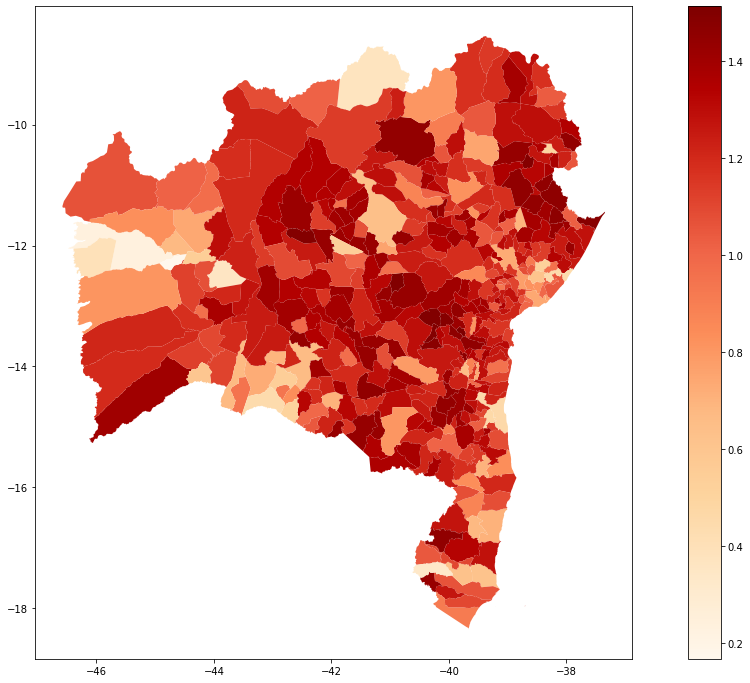

In [ ]:
uf = gera_mapa_uf(mapa_R, 'ba')
uf.plot(column='R', cmap='OrRd', figsize=(20,12), legend=True)